In [22]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import StandardScaler

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [33]:
df = pd.read_csv('data3.csv')
df = df.drop(df.columns[[0]], axis=1)  
df.rename(columns={'0':'x','1':'y','2':'z',
                   '3':'d1','4':'theta2','5':'d3'
                   },inplace=True)

inputs = df.iloc[:, :3].values
outputs = df.iloc[:,3:].values

scaler = StandardScaler()
inputs = scaler.fit_transform(inputs)

In [34]:
inputs = torch.tensor(inputs, dtype=torch.float32)
outputs = torch.tensor(outputs, dtype=torch.float32)

In [35]:
dataset = TensorDataset(inputs, outputs)

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

In [36]:
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
full_loader = DataLoader(dataset, batch_size=64, shuffle=False)

In [37]:
hidden_size = [32, 128, 64, 32]

class AIRModel(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(AIRModel, self).__init__()
        
        layers = []
        prev_size = input_size
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(hidden_size))
            layers.append(nn.Dropout(0.1))  # Light dropout to prevent overfitting
            prev_size = hidden_size
        
        layers.append(nn.Linear(prev_size, output_size))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

    

model = AIRModel(3, hidden_size, 3).to(device)
criterion = nn.L1Loss()  # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5) 


In [38]:
import matplotlib.pyplot as plt
import torch

def train(model, train_loader, val_loader, criterion, optimizer, epochs=100):
    train_losses = []
    val_losses = []

    model.train()
    for epoch in range(epochs):
        train_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
        
        train_loss = train_loss / len(train_loader.dataset)
        train_losses.append(train_loss)

        val_loss = 0.0
        model.eval()
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item() * inputs.size(0)
        
        val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(val_loss)
        
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    # Plotting the losses
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Train and Validation Loss over Epochs')
    plt.show()


In [39]:
def evaluate(model, test_loader, criterion):
    lst=[]
    test_loss = 0.0
    model.eval()
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            print(outputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item() * inputs.size(0)
            lst.append(loss.item())
        print(inputs.size(0))
    
    test_loss = test_loss / len(test_loader.dataset)
    print(f'Test Loss: {test_loss:.4f}')
    print(max(lst))
    print(min(lst))
    

Epoch 1/10, Train Loss: 218.4881, Val Loss: 29.9531
Epoch 2/10, Train Loss: 2.0604, Val Loss: 1.6140
Epoch 3/10, Train Loss: 1.4277, Val Loss: 1.0708
Epoch 4/10, Train Loss: 1.3151, Val Loss: 1.4639
Epoch 5/10, Train Loss: 1.2396, Val Loss: 1.3052
Epoch 6/10, Train Loss: 1.1701, Val Loss: 1.1801
Epoch 7/10, Train Loss: 1.1301, Val Loss: 0.9627
Epoch 8/10, Train Loss: 1.0742, Val Loss: 0.8187
Epoch 9/10, Train Loss: 1.0717, Val Loss: 1.2017
Epoch 10/10, Train Loss: 1.0373, Val Loss: 1.2288


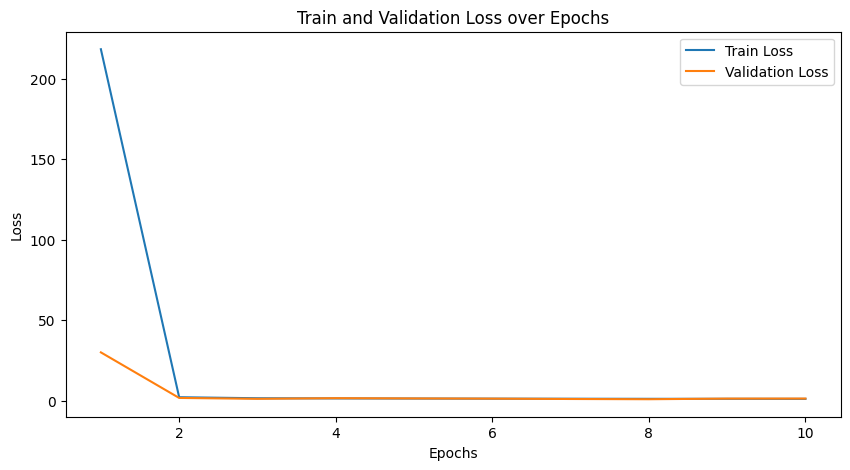

In [40]:
train(model, train_loader, val_loader, criterion, optimizer, epochs=10)

In [41]:
hidden_size = [128, 64, 32]

class AIRModel(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(AIRModel, self).__init__()
        
        layers = []
        prev_size = input_size
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(hidden_size))
            layers.append(nn.Dropout(0.1))  # Light dropout to prevent overfitting
            prev_size = hidden_size
        
        layers.append(nn.Linear(prev_size, output_size))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

    

model = AIRModel(3, hidden_size, 3).to(device)
criterion = nn.L1Loss()  # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5) 


Epoch 1/10, Train Loss: 217.3593, Val Loss: 20.8519
Epoch 2/10, Train Loss: 1.5738, Val Loss: 1.1643
Epoch 3/10, Train Loss: 1.1085, Val Loss: 1.1170
Epoch 4/10, Train Loss: 0.9888, Val Loss: 0.9304
Epoch 5/10, Train Loss: 0.9445, Val Loss: 0.9939
Epoch 6/10, Train Loss: 0.9140, Val Loss: 1.2046
Epoch 7/10, Train Loss: 0.8538, Val Loss: 0.7887
Epoch 8/10, Train Loss: 0.8445, Val Loss: 0.5325
Epoch 9/10, Train Loss: 0.8185, Val Loss: 0.6676
Epoch 10/10, Train Loss: 0.7841, Val Loss: 0.7308


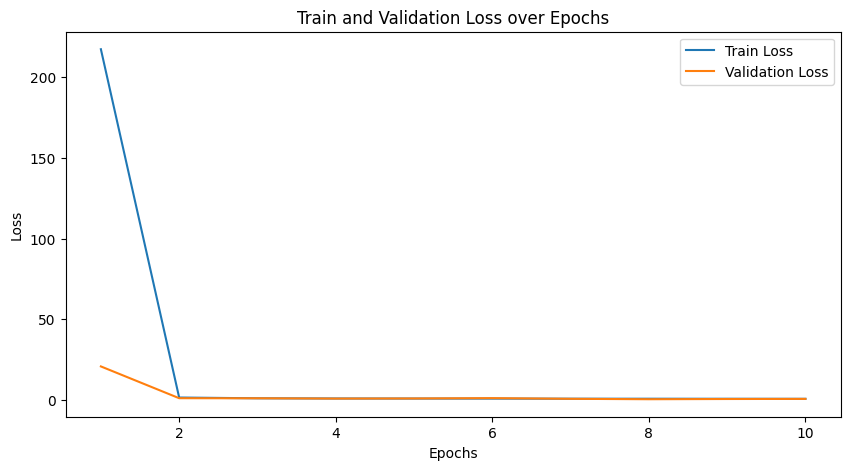

In [42]:
train(model, train_loader, val_loader, criterion, optimizer, epochs=10)